In [1]:
import pandas as pd
import numpy as np
import sys
import lifelines
import random
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, kruskal, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
import statsmodels.stats.multitest as multi
from matplotlib.collections import PatchCollection
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Load in TAD and 156 Cancer Clumped meQTL Data

In [2]:
common_TADs = pd.read_csv("../tads_50kb_boundary.csv")
common_TADs

,Unnamed: 0,chr1,x1,x2,Label
0,0,1,7345000,7660000,Inactive
1,1,1,7295000,7345000,Boundary-Inactive
2,2,1,7660000,7710000,Boundary-Inactive
3,3,1,7710000,7712500,Boundary-Inactive
4,4,1,7712500,7715000,Boundary-Inactive
...,...,...,...,...,...
5429,5429,X,133905000,133955000,Boundary-Inactive
5430,5430,X,149060000,149110000,Boundary-Inactive
5431,5431,X,149160000,149845000,Inactive
5432,5432,X,149110000,149160000,Boundary-Inactive


In [3]:
cancer_meqtls_clumped = pd.read_csv("../new_cancer_meqtls_clumped.csv")
cancer_meqtls_clumped

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,...,rsid,probe_position_hg19,probe_chr_hg38,probe_bp_hg38,probe_bp2_hg38,probe_position_hg38,Promoters,probe_gene,TAD_TYPE_50kb,Probe_Gene_Type
0,16,1,16:74700743:C:G,74700743,2.100000e-88,124,0,0,0,0,...,rs4887783,chr16:74700730,chr16,74666832,74666833,chr16:74666832,True,RFWD3,Boundary-Active,TSG
1,10,1,10:88486374:A:G,88486374,2.990000e-79,97,0,0,0,0,...,rs17335168,chr10:88516091,chr10,86756334,86756335,chr10:86756334,True,BMPR1A,Active,TSG
2,19,1,19:45868478:A:T,45868478,3.200000e-53,14,0,0,0,0,...,rs238407,chr19:45873902,chr19,45370644,45370645,chr19:45370644,True,ERCC2,Inter-TAD,TSG
3,16,1,16:89828862:T:C,89828862,6.350000e-46,143,0,0,0,0,...,rs6500442,chr16:89883248,chr16,89816840,89816841,chr16:89816840,True,FANCA,Active,TSG
4,16,1,16:74482455:G:A,74482455,2.340000e-45,93,0,0,0,0,...,rs1132843,chr16:74700730,chr16,74666832,74666833,chr16:74666832,True,RFWD3,Boundary-Active,TSG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,13,1,13:95136055:G:T,95136055,9.330000e-06,0,0,0,0,0,...,rs9301962,chr13:95364908,chr13,94712654,94712655,chr13:94712654,True,SOX21,Inter-TAD,TSG
152,7,1,7:5584599:G:A,5584599,9.520000e-06,0,0,0,0,0,...,rs1725213,chr7:6413877,chr7,6374246,6374247,chr7:6374246,True,RAC1,Active,Oncogene
153,2,1,2:215840829:G:A,215840829,9.620000e-06,0,0,0,0,0,...,rs7594021,chr2:215675051,chr2,214810327,214810328,chr2:214810327,True,BARD1,Inter-TAD,TSG
154,11,1,11:86261616:C:G,86261616,9.680000e-06,0,0,0,0,0,...,rs17149169,chr11:85956224,chr11,86245182,86245183,chr11:86245182,True,EED,Inactive,TSG


In [4]:
onco_meqtls_clumped = cancer_meqtls_clumped[cancer_meqtls_clumped["Probe_Gene_Type"] == "Oncogene"]
tsg_meqtls_clumped = cancer_meqtls_clumped[cancer_meqtls_clumped["Probe_Gene_Type"] == "TSG"]

In [5]:
cancer_meqtls_clumped.columns

Index(['CHR', 'F', 'SNP', 'BP', 'P', 'TOTAL', 'NSIG', 'S05', 'S01', 'S001',
       'S0001', 'SP2', 'rsid', 'probe_position_hg19', 'probe_chr_hg38',
       'probe_bp_hg38', 'probe_bp2_hg38', 'probe_position_hg38', 'Promoters',
       'probe_gene', 'TAD_TYPE_50kb', 'Probe_Gene_Type'],
      dtype='object')

In [6]:
meqtls = pd.read_csv("../meqtls_tads.csv")
meqtls

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,num,cancer_type,rsid,snp_position,alleles,probes,probe_position,...,beta,status,r,p-value,cancer,chr,bp,SNP,TAD_TYPE,TAD_TYPE_50kb
0,0,0,0,0,BLCA,rs11684598,chr2:33952621,G/A,cg04131969,chr2:33951647,...,-1.24,-40.26,-0.90,3.940000e-139,BLCA,chr2,33952621,2:33952621:G:A,Inter-TAD,Inter-TAD
1,1,1,1,1,BLCA,rs12232965,chr2:33954560,C/T,cg04131969,chr2:33951647,...,-1.24,-39.59,-0.90,6.710000e-137,BLCA,chr2,33954560,2:33954560:C:T,Inter-TAD,Inter-TAD
2,2,2,2,2,BLCA,rs7574695,chr2:33953186,C/T,cg04131969,chr2:33951647,...,-1.24,-39.35,-0.90,4.230000e-136,BLCA,chr2,33953186,2:33953186:C:T,Inter-TAD,Inter-TAD
3,3,3,3,3,BLCA,rs11777332,chr8:91676709,G/A,cg16814680,chr8:91681699,...,-1.20,-36.65,-0.88,8.170000e-127,BLCA,chr8,91676709,8:91676709:G:A,Inter-TAD,Inter-TAD
4,4,4,4,4,BLCA,rs4332092,chr8:91677926,G/A,cg16814680,chr8:91681699,...,-1.20,-36.65,-0.88,8.170000e-127,BLCA,chr8,91677926,8:91677926:G:A,Inter-TAD,Inter-TAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236137,1236137,1236137,1236137,1236137,UCEC,rs60260871,chr3:124711371,C/T,cg11029367,chr3:124705145,...,0.43,4.58,0.35,9.990000e-06,UCEC,chr3,124711371,3:124711371:C:T,Boundary-Active,Boundary-Active
1236138,1236138,1236138,1236138,1236138,UCEC,rs57574713,chr3:124711386,G/A,cg11029367,chr3:124705145,...,0.43,4.58,0.35,9.990000e-06,UCEC,chr3,124711386,3:124711386:G:A,Boundary-Active,Boundary-Active
1236139,1236139,1236139,1236139,1236139,UCEC,rs10903612,chr10:2018353,C/T,cg16296438,chr10:1416569,...,0.36,4.58,0.35,9.990000e-06,UCEC,chr10,2018353,10:2018353:C:T,Neither,Neither
1236140,1236140,1236140,1236140,1236140,UCEC,rs4880953,chr10:2019373,C/T,cg16296438,chr10:1416569,...,0.36,4.58,0.35,9.990000e-06,UCEC,chr10,2019373,10:2019373:C:T,Neither,Neither


In [8]:
meqtls_clumped_list = list(cancer_meqtls_clumped["SNP"])
both_alleles = pd.read_csv("../meqtls_hg19_both_alleles.csv")
meqtls_short = pd.DataFrame()
meqtls_short["SNP"] = both_alleles["SNP"]
meqtls_short["TAD_TYPE_50kb"] = both_alleles["TAD_TYPE_50kb"]
meqtls_short

,SNP,TAD_TYPE_50kb
0,2:33952621:G:A,Inter-TAD
1,2:33952621:A:G,Inter-TAD
2,2:33954560:C:T,Inter-TAD
3,2:33954560:T:C,Inter-TAD
4,2:33953186:C:T,Inter-TAD
...,...,...
2472279,10:2018353:T:C,Neither
2472280,10:2019373:C:T,Neither
2472281,10:2019373:T:C,Neither
2472282,10:79931884:C:T,Inter-TAD


### Use the Non-Cancer meQTLs to Compare with Distribution of Cancer meQTLs in TADs

In [ ]:
noncancer = ~meqtls.SNP.isin(meqtls_clumped_list)
noncancer_meqtls = meqtls[noncancer]
noncancer_meqtls

### Use Minor Allele Frequency to Match SNPs from Cancer to Non-Cancer for Randomization Analysis

In [10]:
maf_file = open("/cellar/users/sgoudarzi/input_meqtl_mafs.txt", "r")
maf_read = maf_file.readlines()

In [13]:
mafs = maf_read[0].split(" ")
maf_np = []
for el in mafs:
    l = el.split("/")
    maf_np.append([l[0], float(l[1]), float(l[2])])
maf_np = np.array(maf_np)

In [14]:
meqtl_mafs = pd.DataFrame(maf_np)
meqtl_mafs = meqtl_mafs.rename(columns={0:"SNP", 1:"lo_maf", 2:"hi_maf"})
meqtl_mafs = pd.merge(meqtl_mafs, meqtls_short, on="SNP")
meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_TYPE_50kb
0,1:752721:G:A,0.18582,0.20538,Neither
1,1:753405:A:C,0.14459,0.15980999999999998,Neither
2,1:753541:G:A,0.14382999999999999,0.15897,Neither
3,1:754182:G:A,0.145065,0.16033499999999998,Neither
4,1:754192:G:A,0.145065,0.16033499999999998,Neither
...,...,...,...,...
966006,22:51098764:G:A,0.200355,0.22144499999999998,Neither
966007,22:51099671:T:C,0.226575,0.250425,Neither
966008,22:51099862:C:T,0.194275,0.214725,Neither
966009,22:51158017:G:C,0.431205,0.4765950000000001,Neither


In [15]:
chr1 = []
bp = []
for i, row in meqtl_mafs.iterrows():
    lst = row["SNP"].split(":")
    chr1.append(int(lst[0]))
    bp.append(int(lst[1]))
meqtl_mafs["chr"] = chr1
meqtl_mafs["bp"] = bp
meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_TYPE_50kb,chr,bp
0,1:752721:G:A,0.18582,0.20538,Neither,1,752721
1,1:753405:A:C,0.14459,0.15980999999999998,Neither,1,753405
2,1:753541:G:A,0.14382999999999999,0.15897,Neither,1,753541
3,1:754182:G:A,0.145065,0.16033499999999998,Neither,1,754182
4,1:754192:G:A,0.145065,0.16033499999999998,Neither,1,754192
...,...,...,...,...,...,...
966006,22:51098764:G:A,0.200355,0.22144499999999998,Neither,22,51098764
966007,22:51099671:T:C,0.226575,0.250425,Neither,22,51099671
966008,22:51099862:C:T,0.194275,0.214725,Neither,22,51099862
966009,22:51158017:G:C,0.431205,0.4765950000000001,Neither,22,51158017


In [16]:
noncancer = ~meqtl_mafs.SNP.isin(meqtls_clumped_list)
noncancer_meqtls_mafs = meqtl_mafs[noncancer]
noncancer_meqtls_mafs = noncancer_meqtls_mafs.reset_index(drop=True)
noncancer_meqtls_mafs['lo_maf'] = noncancer_meqtls_mafs['lo_maf'].astype(float)
noncancer_meqtls_mafs['hi_maf'] = noncancer_meqtls_mafs['hi_maf'].astype(float)
noncancer_meqtls_mafs["maf"] = np.array(noncancer_meqtls_mafs["lo_maf"])/0.95
noncancer_meqtls_mafs

,SNP,lo_maf,hi_maf,TAD_TYPE_50kb,chr,bp,maf
0,1:752721:G:A,0.185820,0.205380,Neither,1,752721,0.1956
1,1:753405:A:C,0.144590,0.159810,Neither,1,753405,0.1522
2,1:753541:G:A,0.143830,0.158970,Neither,1,753541,0.1514
3,1:754182:G:A,0.145065,0.160335,Neither,1,754182,0.1527
4,1:754192:G:A,0.145065,0.160335,Neither,1,754192,0.1527
...,...,...,...,...,...,...,...
965850,22:51098764:G:A,0.200355,0.221445,Neither,22,51098764,0.2109
965851,22:51099671:T:C,0.226575,0.250425,Neither,22,51099671,0.2385
965852,22:51099862:C:T,0.194275,0.214725,Neither,22,51099862,0.2045
965853,22:51158017:G:C,0.431205,0.476595,Neither,22,51158017,0.4539


In [17]:
cancer = meqtl_mafs.SNP.isin(meqtls_clumped_list)
cancer_meqtl_mafs = meqtl_mafs[cancer]
cancer_meqtl_mafs = cancer_meqtl_mafs.reset_index(drop=True)
cancer_meqtl_mafs['lo_maf'] = cancer_meqtl_mafs['lo_maf'].astype(float)
cancer_meqtl_mafs['hi_maf'] = cancer_meqtl_mafs['hi_maf'].astype(float)
cancer_meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_TYPE_50kb,chr,bp
0,1:15817090:C:T,0.294500,0.325500,Neither,1,15817090
1,1:15914135:A:G,0.123690,0.136710,Active,1,15914135
2,1:18247811:G:T,0.190285,0.210315,Inter-TAD,1,18247811
3,1:18273842:G:T,0.262960,0.290640,Inter-TAD,1,18273842
4,1:18774941:T:A,0.068505,0.075715,Inter-TAD,1,18774941
...,...,...,...,...,...,...
151,20:57375308:C:T,0.241490,0.266910,Inter-TAD,20,57375308
152,20:58315732:T:C,0.049999,0.055261,Inter-TAD,20,58315732
153,20:58353666:A:G,0.216505,0.239295,Inter-TAD,20,58353666
154,22:24146560:T:C,0.069141,0.076419,Inter-TAD,22,24146560


### Run the Analysis for Both TSG and Oncogene Related Clumped meQTLs

In [18]:
tsg = meqtl_mafs.SNP.isin(list(tsg_meqtls_clumped["SNP"]))
tsg_meqtl_mafs = meqtl_mafs[tsg]
tsg_meqtl_mafs = tsg_meqtl_mafs.reset_index(drop=True)
tsg_meqtl_mafs['lo_maf'] = tsg_meqtl_mafs['lo_maf'].astype(float)
tsg_meqtl_mafs['hi_maf'] = tsg_meqtl_mafs['hi_maf'].astype(float)
tsg_meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_TYPE_50kb,chr,bp
0,1:15817090:C:T,0.294500,0.325500,Neither,1,15817090
1,1:15914135:A:G,0.123690,0.136710,Active,1,15914135
2,1:18247811:G:T,0.190285,0.210315,Inter-TAD,1,18247811
3,1:18273842:G:T,0.262960,0.290640,Inter-TAD,1,18273842
4,1:18774941:T:A,0.068505,0.075715,Inter-TAD,1,18774941
...,...,...,...,...,...,...
97,19:45868478:A:T,0.419140,0.463260,Inter-TAD,19,45868478
98,19:45878605:C:T,0.139270,0.153930,Inter-TAD,19,45878605
99,19:45923653:A:G,0.362710,0.400890,Inter-TAD,19,45923653
100,22:24146560:T:C,0.069141,0.076419,Inter-TAD,22,24146560


In [19]:
onco = meqtl_mafs.SNP.isin(list(onco_meqtls_clumped["SNP"]))
onco_meqtl_mafs = meqtl_mafs[onco]
onco_meqtl_mafs = onco_meqtl_mafs.reset_index(drop=True)
onco_meqtl_mafs['lo_maf'] = onco_meqtl_mafs['lo_maf'].astype(float)
onco_meqtl_mafs['hi_maf'] = onco_meqtl_mafs['hi_maf'].astype(float)
onco_meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_TYPE_50kb,chr,bp
0,1:163436669:G:T,0.036594,0.040446,Inter-TAD,1,163436669
1,2:44246726:G:C,0.452010,0.499590,Boundary-Mixed,2,44246726
2,2:60889037:C:G,0.457615,0.505785,Inter-TAD,2,60889037
3,2:61250101:A:C,0.227145,0.251055,Inter-TAD,2,61250101
4,2:61338832:T:C,0.423415,0.467985,Inter-TAD,2,61338832
5,2:61437487:T:C,0.384370,0.424830,Inter-TAD,2,61437487
6,2:61485267:T:C,0.212325,0.234675,Inter-TAD,2,61485267
7,2:61515164:T:C,0.474335,0.524265,Inter-TAD,2,61515164
8,2:61540642:C:A,0.305140,0.337260,Inter-TAD,2,61540642
9,2:61623476:T:C,0.141930,0.156870,Inter-TAD,2,61623476


In [20]:
frames2 = [tsg_meqtl_mafs, onco_meqtl_mafs]
all_meqtl_mafs = pd.concat(frames2)
all_meqtl_mafs = all_meqtl_mafs.reset_index(drop=True)
all_meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_TYPE_50kb,chr,bp
0,1:15817090:C:T,0.294500,0.325500,Neither,1,15817090
1,1:15914135:A:G,0.123690,0.136710,Active,1,15914135
2,1:18247811:G:T,0.190285,0.210315,Inter-TAD,1,18247811
3,1:18273842:G:T,0.262960,0.290640,Inter-TAD,1,18273842
4,1:18774941:T:A,0.068505,0.075715,Inter-TAD,1,18774941
...,...,...,...,...,...,...
151,20:50431113:C:T,0.044109,0.048751,Inter-TAD,20,50431113
152,20:56648906:G:A,0.089367,0.098774,Inter-TAD,20,56648906
153,20:57375308:C:T,0.241490,0.266910,Inter-TAD,20,57375308
154,20:58315732:T:C,0.049999,0.055261,Inter-TAD,20,58315732


In [50]:
num_pairs_tads = [0, 0]
num_pairs_boundary = 0;
for i, row in common_TADs.iterrows():
    if (row["Label"] == "Active"):
        num_pairs_tads[0] += row["x2"]-row["x1"]
    if row["Label"] == "Inactive":
        num_pairs_tads[1] += row["x2"]-row["x1"]
    if "Boundary" in row["Label"]:
        if "Mixed" not in row["Label"]:
            num_pairs_boundary += row["x2"]-row["x1"]

In [22]:
def count_meqtls(new_meqtls):
    temp = common_TADs.copy()
    lst = []
    for i, row in temp.iterrows():
        common_chr = new_meqtls[new_meqtls["chr"] == row["chr1"]]
        snps = common_chr[(common_chr["bp"] >= row["x1"]) & (common_chr["bp"] <= row["x2"])]
        lst.append(len(snps)/(row["x2"]-row["x1"]))
    temp["count"] = lst
    temp_active = temp[temp["Label"] == "Active"]
    temp_inactive = temp[temp["Label"] == "Inactive"]
    temp_boundary = temp[temp["Label"].str.contains("Boundary")]
    return np.mean(np.array(temp_active["count"])), np.mean(np.array(temp_inactive["count"])), np.mean(np.array(temp_boundary["count"]))

### Conduct 1000 trials of Randomized Analysis Calculating Burden of Cancer meQTLs in Each TAD Category

#### Analysis for Oncogene-Related meQTLS

In [23]:
active_num_onco = []
inactive_num_onco = []
boundary_num_onco = []

for j in range(1000):
    if j % 100 == 0:
        print(j)
    r_snps = set()
    for i, row in onco_meqtl_mafs.iterrows():
        matched = noncancer_meqtls_mafs[(noncancer_meqtls_mafs["maf"]>=row["lo_maf"]) & (noncancer_meqtls_mafs["maf"]<=row["hi_maf"])]
        r_snps.add(random.choice(list(set(matched["SNP"]) - r_snps)))
    onco_rand = meqtl_mafs.SNP.isin(list(r_snps))
    rand_snps = meqtl_mafs[onco_rand]

    try:
        active_num_onco.append(rand_snps["TAD_TYPE_50kb"].value_counts()["Active"])
    except:
        active_num_onco.append(0)
    try:
        inactive_num_onco.append(rand_snps["TAD_TYPE_50kb"].value_counts()["Inactive"])
    except: 
        inactive_num_onco.append(0)
    try: 
        boundary_num_onco.append(len(rand_snps[rand_snps["TAD_TYPE_50kb"].str.contains("Boundary")]))
    except:
        boundary_num_onco.append(0)

active_mean_num_onco = np.mean(active_num_onco)
inactive_mean_num_onco = np.mean(inactive_num_onco)
boundary_mean_num_onco = np.mean(boundary_num_onco)

0
100
200
300
400
500
600
700
800
900


In [24]:
active_mean_num_onco = np.mean(np.array(active_num_onco)/num_pairs_tads[0])
inactive_mean_num_onco = np.mean(np.array(inactive_num_onco)/num_pairs_tads[1])
boundary_mean_num_onco = np.mean(np.array(boundary_num_onco)/num_pairs_boundary)
# active_mean_num_onco = np.mean(np.array(active_num_onco))
# inactive_mean_num_onco = np.mean(np.array(inactive_num_onco))
# boundary_mean_num_onco = np.mean(np.array(boundary_num_onco))

In [25]:
active_std_onco = np.std(np.array(active_num_onco)/num_pairs_tads[0])
inactive_std_onco = np.std(np.array(inactive_num_onco)/num_pairs_tads[1])
boundary_std_onco = np.std(np.array(boundary_num_onco)/num_pairs_boundary)
# active_std_onco = np.std(np.array(active_num_onco))
# inactive_std_onco = np.std(np.array(inactive_num_onco))
# boundary_std_onco = np.std(np.array(boundary_num_onco))

#### Analysis for TSG-Related meQTLs

In [26]:
active_num_tsg = []
inactive_num_tsg = []
boundary_num_tsg = []
for j in range(1000):
    if j % 100 == 0:
        print(j)
    r_snps = set()
    for i, row in tsg_meqtl_mafs.iterrows():
        matched = noncancer_meqtls_mafs[(noncancer_meqtls_mafs["maf"]>=row["lo_maf"]) & (noncancer_meqtls_mafs["maf"]<=row["hi_maf"])]
        r_snps.add(random.choice(list(set(matched["SNP"]) - r_snps)))
    tsg_rand = meqtl_mafs.SNP.isin(list(r_snps))
    rand_snps = meqtl_mafs[tsg_rand]
#     num_active, num_inactive, num_boundary = count_meqtls(rand_snps)
#     active_num_tsg.append(num_active)
#     inactive_num_tsg.append(num_inactive)
#     boundary_num_tsg.append(num_boundary)
    try:
        active_num_tsg.append(rand_snps["TAD_TYPE_50kb"].value_counts()["Active"])
    except:
        active_num_tsg.append(0)
    try:
        inactive_num_tsg.append(rand_snps["TAD_TYPE_50kb"].value_counts()["Inactive"])
    except:
        inactive_num_tsg.append(0)
    try:
        boundary_num_tsg.append(len(rand_snps[rand_snps["TAD_TYPE_50kb"].str.contains("Boundary")]))
    except:
        boundary_num_tsg.append(0)

active_mean_num_tsg = np.mean(active_num_tsg)
inactive_mean_num_tsg = np.mean(inactive_num_tsg)
boundary_mean_num_tsg = np.mean(boundary_num_tsg)

0
100
200
300
400
500
600
700
800
900


In [27]:
active_mean_num_tsg = np.mean(np.array(active_num_tsg)/num_pairs_tads[0])
inactive_mean_num_tsg = np.mean(np.array(inactive_num_tsg)/num_pairs_tads[1])
boundary_mean_num_tsg = np.mean(np.array(boundary_num_tsg)/num_pairs_boundary)
# active_mean_num_tsg = np.mean(np.array(active_num_tsg))
# inactive_mean_num_tsg = np.mean(np.array(inactive_num_tsg))
# boundary_mean_num_tsg = np.mean(np.array(boundary_num_tsg))

In [28]:
active_std_tsg = np.std(np.array(active_num_tsg)/num_pairs_tads[0])
inactive_std_tsg = np.std(np.array(inactive_num_tsg)/num_pairs_tads[1])
boundary_std_tsg = np.std(np.array(boundary_num_tsg)/num_pairs_boundary)
# active_std_tsg = np.std(np.array(active_num_tsg))
# inactive_std_tsg = np.std(np.array(inactive_num_tsg))
# boundary_std_tsg = np.std(np.array(boundary_num_tsg))

### Draw Bar Plot with Standard Errors for Both Oncogene and TSG Distribution Analysis

<Figure size 1080x1440 with 0 Axes>

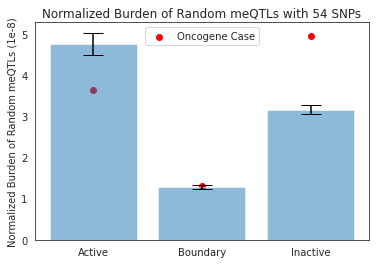

In [54]:
tad_activity1 = ['Active', 'Boundary', 'Inactive']
plt.figure(figsize =(15, 20))
x_pos1 = np.arange(len(tad_activity1))
CTEs1 = [active_mean_num_onco, boundary_mean_num_onco, inactive_mean_num_onco]
error1 = [2*active_std_onco/np.sqrt(1000), 2*boundary_std_onco/np.sqrt(1000), 2*inactive_std_onco/np.sqrt(1000)]
fig1, ax1 = plt.subplots()
ax1.bar(x_pos1, CTEs1, yerr=error1, align='center', alpha=0.5, ecolor='black', capsize=10)
ax1.set_ylabel('Normalized Burden of Random meQTLs (1e-8)')
ax1.set_xticks(x_pos1)
ax1.set_xticklabels(tad_activity1)
ax1.set_title('Normalized Burden of Random meQTLs with 54 SNPs')
ax1.yaxis.grid(True)
ax1.scatter(x_pos1[0], onco_meqtls_clumped["TAD_TYPE_50kb"].value_counts()["Active"]/num_pairs_tads[0], color = "red")
ax1.scatter(x_pos1[1], len(onco_meqtls_clumped[onco_meqtls_clumped["TAD_TYPE_50kb"].str.contains("Boundary")])/num_pairs_boundary, color = "red")
ax1.scatter(x_pos1[2], onco_meqtls_clumped["TAD_TYPE_50kb"].value_counts()["Inactive"]/num_pairs_tads[1], color = "red")
plt.grid(False)
ax1.yaxis.get_offset_text().set_visible(False)
plt.legend(["Oncogene Case"], loc="upper center")
plt.savefig("../plots/new_oncogene_SNP_randomization.pdf")
plt.savefig("../plots/new_oncogene_SNP_randomization.png")
plt.show()

<Figure size 1080x1440 with 0 Axes>

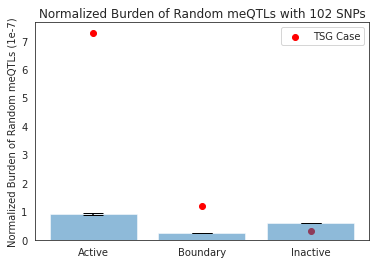

In [53]:
tad_activity2 = ['Active', 'Boundary', 'Inactive']
plt.figure(figsize =(15, 20))
x_pos2 = np.arange(len(tad_activity2))
CTEs2 = [active_mean_num_tsg, boundary_mean_num_tsg, inactive_mean_num_tsg]
error2 = [2*active_std_tsg/np.sqrt(1000), 2*boundary_std_tsg/np.sqrt(1000), 2*inactive_std_tsg/np.sqrt(1000)]
fig2, ax2 = plt.subplots()
ax2.bar(x_pos2, CTEs2, yerr=error2, align='center', alpha=0.5, ecolor='black', capsize=10)
ax2.set_ylabel('Normalized Burden of Random meQTLs (1e-7)')
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(tad_activity2)
ax2.set_title('Normalized Burden of Random meQTLs with 102 SNPs')
ax2.yaxis.grid(True)
ax2.scatter(x_pos2[0], tsg_meqtls_clumped["TAD_TYPE_50kb"].value_counts()["Active"]/num_pairs_tads[0], color = "red")
ax2.scatter(x_pos2[1], len(tsg_meqtls_clumped[tsg_meqtls_clumped["TAD_TYPE_50kb"].str.contains("Boundary")])/num_pairs_boundary, color = "red")
ax2.scatter(x_pos2[2], tsg_meqtls_clumped["TAD_TYPE_50kb"].value_counts()["Inactive"]/num_pairs_tads[1], color = "red")
plt.grid(False)
ax2.yaxis.get_offset_text().set_visible(False)
plt.legend(["TSG Case"], loc="upper right")
plt.savefig("../plots/new_tsg_SNP_randomization.pdf")
plt.savefig("../plots/new_tsg_SNP_randomization.png")
plt.show()